### GP Regression in TF

Using tensorflow, I will attempt to model the log of the rosenbrock function:

$$
f: \mathbb{R}^2 \mapsto \mathbb{R} \\
f(x,y) = \log\left[(a-x)^2 + b(y-x^2)^2\right] \\
$$

Specifically, I want to use a small number of the points to parameterize the full function using a sparse GP. We'll try to optimize the location of the points and their Y values in addition to the kernel parameters. 

In [1]:
%pylab inline
import tensorflow as tf
import numpy as np
from tqdm.autonotebook import tqdm

Populating the interactive namespace from numpy and matplotlib


/home/kmdalton/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


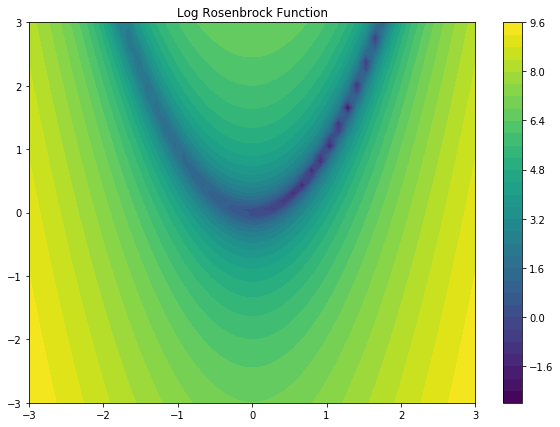

In [72]:
a,b = 1.0,100. 
x = y = np.linspace(-3, 3, 50)
x,y = np.meshgrid(x, y)
z = np.log((a - x)**2 + b*(y - x**2)**2)

Xstar = np.vstack((x.flatten(),y.flatten())).T.astype(np.float32)
Ystar = z.flatten().astype(np.float32)

plt.figure(figsize=(10,7))
plt.contourf(x, y, z, 30)
plt.colorbar()
plt.title("Log Rosenbrock Function")


num_prototypes = 100

idx = np.random.choice(np.arange(len(Xstar)), num_prototypes)
X = Xstar[idx]
Y = Ystar[idx]


[]

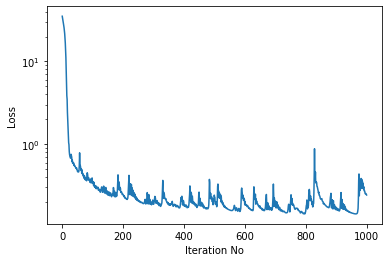

In [77]:
class RBF():
    def __init__(self, variance, lengthscale):
        self.variance=variance
        self.lengthscale=lengthscale
    def __call__(self, X, Z=None):
        if Z is None:
            Z = X
        R = (X[:,None,:] - Z[None,:,:])/self.lengthscale
        return self.variance*tf.exp(-0.5*tf.reduce_sum(R**2, -1))

class Matern32():
    def __init__(self, variance, lengthscale):
        self.variance=variance
        self.lengthscale=lengthscale
    def __call__(self, X, Z=None):
        if Z is None:
            Z = X
        R = tf.reduce_sum(tf.abs(X[:,None,:] - Z[None,:,:])/self.lengthscale, -1)
        return self.variance*(1. + 3**0.5*R) * tf.exp(-3**0.5*R)

class Matern52():
    def __init__(self, variance, lengthscale):
        self.variance=variance
        self.lengthscale=lengthscale
    def __call__(self, X, Z=None):
        if Z is None:
            Z = X
        R = tf.abs(X[:,None,:] - Z[None,:,:])/self.lengthscale
        F = self.variance*(1 + 5**0.5*tf.reduce_sum(R, -1) + 5*tf.reduce_sum(R**2, -1)/3)
        E = tf.exp(-5**0.5*tf.reduce_sum(R, -1))
        return F*E

class SumKernel():
    def __init__(self, k1, k2):
        self.k1 = k1
        self.k2 = k2
    def __call__(self, X, Z=None):
        return self.k1(X, Z) + self.k2(X, Z)
 
class ProductKernel():
    def __init__(self, k1, k2):
        self.k1 = k1
        self.k2 = k2
    def __call__(self, X, Z=None):
        return self.k1(X, Z) * self.k2(X, Z)

def softclip(tensor, minvals, maxvals):
    """
    Parameters
    ----------
    tensor : tensor
        N x D tensor of data
    minvals : float or tensor
        Float or D dimensional tensor
    maxvals : float or tensor
        Float or D dimensional tensor
    """
    ranges = maxvals - minvals
    return tf.math.sigmoid(tensor) * ranges + minvals
    

#Instantiate all the variables we need for the problem
xmin = -2.
xmax = np.array([2., 2.], dtype=np.float32)
D = X.shape[1]
variables = (
    tf.Variable(X, dtype=tf.float32), 
    tf.Variable(np.ones(Y.shape), dtype=tf.float32), 
    tf.Variable(np.ones(Y.shape), dtype=tf.float32),
    tf.Variable(1., dtype=tf.float32), 
    tf.Variable(tf.ones(D), dtype=tf.float32),
    tf.Variable(1., dtype=tf.float32), 
    tf.Variable(tf.ones(D), dtype=tf.float32),
)
#Give the variables handy short names
X,Y,Y_variance,k1_variance,k1_lengthscale,k2_variance,k2_lengthscale = variables

@tf.function
def predict():
    """predict Ystar with sparse gp"""
    #Make our kernel instance
    kernel = SumKernel(
        Matern32(
            tf.math.softplus(k1_variance), 
            tf.math.softplus(k1_lengthscale)
        ),
        RBF(
            tf.math.softplus(k2_variance), 
            tf.math.softplus(k2_lengthscale)
        )
    )

    #X_ = softclip(X, xmin, xmax)
    X_ = X
    KXX = kernel(X_, X_) + tf.linalg.diag(tf.math.softplus(Y_variance))
    KXstarX = kernel(Xstar, X_)
    Ypred = (KXstarX @ tf.linalg.inv(KXX) @ Y[:,None])[:,0]
    return Ypred
    

Ypred = predict()

#Make an Adam instance
opt = tf.keras.optimizers.Adam(0.1)
xtrace = []
ztrace = []
maxiter=1000
losses = []
for i in tqdm(range(maxiter)):
    with tf.GradientTape() as tape:
        Ypred = predict()
        ztrace.append(Ypred.numpy().reshape((x.shape[1], x.shape[1])))
        #X_ = softclip(X, xmin, xmax)
        xtrace.append(X.numpy())
        loss = tf.keras.losses.MSE(Ypred, Ystar) 
        losses.append(loss)
    grads = tape.gradient(loss, variables)
    opt.apply_gradients(zip(grads, variables))

plt.figure()
plt.plot(losses)
plt.xlabel("Iteration No")
plt.ylabel("Loss")
plt.semilogy()

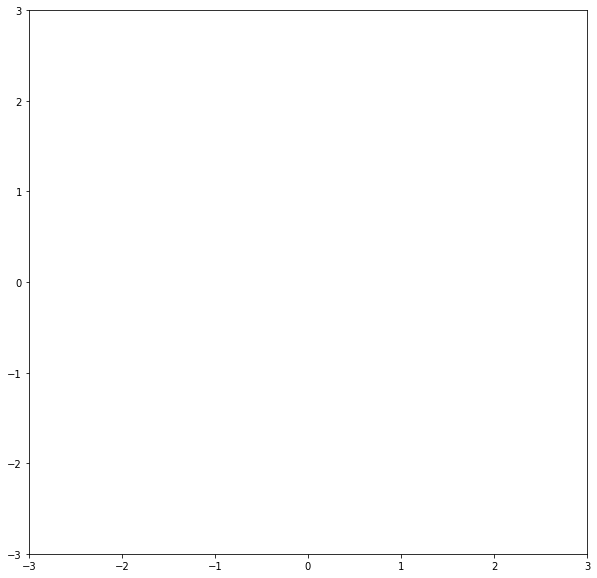

In [79]:
from celluloid import Camera
from IPython.display import HTML

levels=30
stride = 10

f,ax = plt.subplots(figsize=(10, 10))
plt.contourf(x, y, ztrace[0], levels)
xlim = plt.xlim()
ylim = plt.ylim()
plt.plot(*xtrace[i].T, 'wo', alpha=0.5, scalex=False, scaley=False)
cam = Camera(f)

for i in tqdm(range(0, len(xtrace), stride)):
    plt.contourf(x, y, ztrace[i], levels)
    plt.plot(*xtrace[i].T, 'wo', alpha=0.5, scalex=False, scaley=False)
    plt.xlim(xlim)
    plt.ylim(ylim)
    cam.snap()

anim = cam.animate()
HTML(anim.to_html5_video())